In [440]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import h5py
import itertools as IT
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
from matplotlib.patches import ConnectionPatch
from matplotlib.pyplot import cm
from statistics import mean
import pandas as pd
import statistics

In [441]:
f = h5py.File('working_/rec/herdingspikes/HS2_sorted.hdf5','r') 

In [442]:
a = np.array([[1,2,3],[5,3,4],[7,8,10]])
b = np.vstack((a[0,1],a[1,2]))  #takes element at index 1 from list at index 0 -> a[0,1]
print(b)

[[2]
 [4]]


In [443]:
spike_time = f['times'][()]   #moment in time when each spike was detected 
sf = 30000 #sampling frequency 
maxt = max(spike_time)/sf    #divide by sf to get the time in seconds
print(maxt)

1956.9483333333333


In [444]:
spike_loc = f['data'][()]
print(spike_loc.shape)           #location of each spike in 2d
#t0 =0
#t1 = 300000
#inds = np.where ((spike_time>=t0) & (spike_time<t1) & (spike_loc[1]<1800) & (spike_loc[1]>1200))[0]
#X_clust = np.vstack((spike_loc[0,inds], spike_loc[1,inds]))
#print(X_clust.shape)
#print(inds.shape)


(2, 973012)


# Clustering

Number of clusters for time interval 0: 71
Number of clusters for time interval 1: 73
Number of clusters for time interval 2: 68
Number of clusters for time interval 3: 87
Number of clusters for time interval 4: 81
Number of clusters for time interval 5: 81
Number of clusters for time interval 6: 78
Number of clusters for time interval 7: 81
Number of clusters for time interval 8: 79
Number of clusters for time interval 9: 77
Number of clusters for time interval 10: 87
Number of clusters for time interval 11: 85
Number of clusters for time interval 12: 65
Number of clusters for time interval 13: 37
Number of clusters for time interval 14: 41
Number of clusters for time interval 15: 44
Number of clusters for time interval 16: 48
Number of clusters for time interval 17: 55
Number of clusters for time interval 18: 56
Number of clusters for time interval 19: 60
Number of clusters for time interval 20: 59
Number of clusters for time interval 21: 57
Number of clusters for time interval 22: 6

([<matplotlib.axis.XTick at 0x7f424efc2710>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

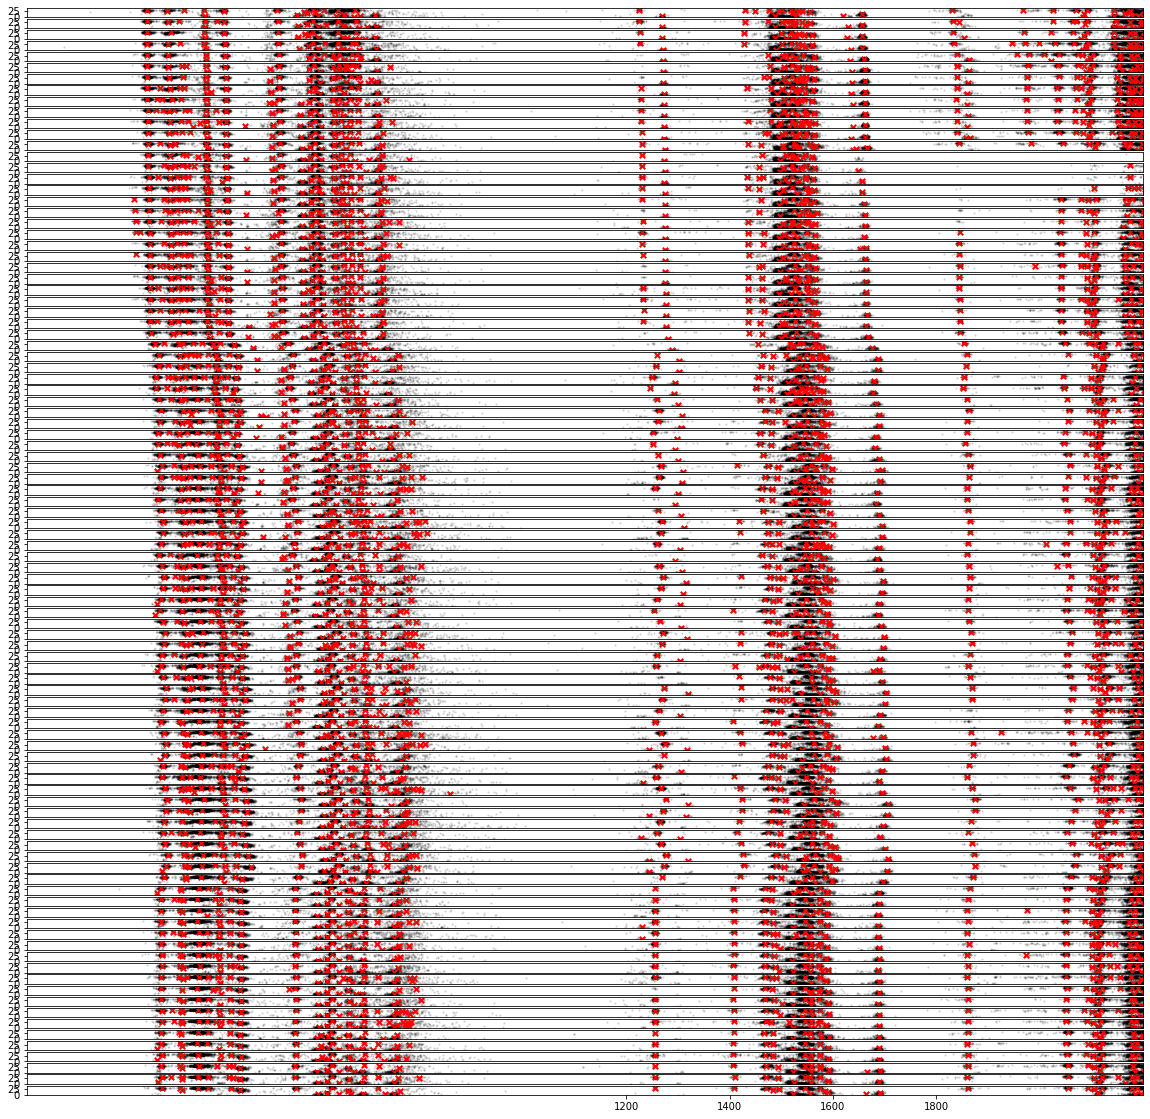

In [445]:
plt.figure(figsize=(20,20))
ms = MeanShift(bandwidth=6.5, bin_seeding=True, min_bin_freq=6)
count =0 
cluster_centers_tf= []
time_frames = []
dt = 20
steps = np.arange(0,int(maxt),dt)
for j,i in enumerate(steps):
    count +=1
    t0=i*sf      #i*300k for every step
    t1=(i+dt)*sf  #take value of the next time step
    
    inds = np.where ((spike_time>=t0) & (spike_time<t1))[0]# & (spike_loc[1]<1800) & (spike_loc[1]>1200)
    X_clust = np.vstack((spike_loc[0,inds], spike_loc[1,inds]))
    #clustering
    ms.fit(X_clust.T)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters = len(np.unique(labels))
    print('Number of clusters for time interval %d: %d' %(j, n_clusters))
    cluster_centers_tf.append(cluster_centers)
    time_frames.append(j)
    if i%10==0:# and count>20 and count <80:     #for each time stamp
        ax = plt.subplot(len(steps),1,j+1)     #nrows, nrcols, plot_no
        y = X_clust[0][:]
        x = X_clust[1][:]
        
        ax.scatter(x,y, s=2, alpha=0.1, c='k')
        ax.scatter(cluster_centers[:,1], cluster_centers[:,0], marker="x", color='r', s=30, linewidths=2)
        #plt.ylabel('{:d}s'.format(int(t0/sf)))
    
        plt.xlim((40,2200))        #Get or set the x limits of the current axes
        #plt.xlim((1200,1800))
        plt.ylim((0,40))
        plt.xticks(())
plt.xticks((1200,1400,1600,1800))   


In [217]:
np.unique(labels,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([775, 350, 569, 449, 346, 335, 263, 389, 238, 226, 203, 222, 206,
        199, 166, 208, 161, 205, 153, 168, 143, 143, 135, 131, 101, 133,
        137, 137, 109, 106,  77,  76, 116,  99,  70, 149,  71,  91,  69,
         54,  56,  41,  50,  30,  58,  49,  31,  35,  41,  25,  44,  38,
         26,  30,  24,  31,  20,  27,  63,  17]))

# Matching Algorithm

In [446]:
tf_dict = {}
tf_dict_dif = {}
ll_drifts=[]
#dict_cluster_positions={}
cluster_positions={}
for t in range(len(time_frames)-1):
    
    #construct the distance matrix for every two consecutive time frames
    dist_matrix = np.zeros((len(cluster_centers_tf[t]), len(cluster_centers_tf[t+1])))
    for k,i in enumerate(cluster_centers_tf[t]):
        for l,j in enumerate(cluster_centers_tf[t+1]):
            dist_matrix[k][l] = distance.euclidean(i,j)
    
    #transform the matrix to a np array
    npdist_matrix = np.array(dist_matrix)
    list_of_indices = []
    dict_of_drifts = {}
    list_of_drifts = []
    cluster_position = {}
    while np.min(npdist_matrix)<100:
        
        #index of the minimum element of the matrix
        min_dist = np.argmin(npdist_matrix)
        #indexes of the corresponding clusters
        x,y = np.unravel_index(min_dist, np.array(npdist_matrix).shape)
        list_of_indices.append((x,y))
        #list_of_drifts.append(cluster_centers_tf[t][x] - cluster_centers_tf[t+1][y])
        list_of_drifts.append(cluster_centers_tf[t+1][y] - cluster_centers_tf[t][x])
        #dict_of_drifts[(x,y)] = cluster_centers_tf[t][x] - cluster_centers_tf[t+1][y]
        dict_of_drifts[(x,y)] = cluster_centers_tf[t+1][y] - cluster_centers_tf[t][x]
        #cluster_position[(x,y)]= ((cluster_centers_tf[t][x], cluster_centers_tf[t+1][y]))
        cluster_position[(x,y)]= ((cluster_centers_tf[t+1][y], cluster_centers_tf[t][x]))
        npdist_matrix[x,:] = 1e6
        npdist_matrix[:,y] = 1e6
        
    tf_dict[(t,t+1)] = list_of_indices
    tf_dict_dif[(t,t+1)] = dict_of_drifts
    cluster_positions[(t,t+1)] = cluster_position
    ll_drifts.append(list_of_drifts)

In [33]:
print(cluster_positions)

{(0, 1): {(16, 16): (array([   2.25356478, 2215.73647683]), array([2.21079563e+00, 2.21565521e+03])), (0, 0): (array([   2.80155218, 1487.41860679]), array([   2.89150039, 1487.45885862])), (2, 2): (array([  11.41878997, 1655.80110534]), array([  11.24710071, 1655.82236925])), (3, 3): (array([ 31.5624394 , 592.50502217]), array([ 31.51076385, 592.67201974])), (28, 29): (array([   2.36109249, 1269.05552178]), array([   2.56498611, 1268.98636807])), (4, 4): (array([  4.59986456, 602.44683488]), array([  4.67769858, 602.7618213 ])), (9, 7): (array([ 28.15875136, 271.68655405]), array([ 28.49725333, 271.62202102])), (53, 47): (array([   4.24038892, 2352.83736821]), array([   4.01463848, 2353.1083213 ])), (27, 32): (array([  28.98619963, 2070.96370035]), array([  28.61969835, 2071.03861017])), (1, 1): (array([ 30.55767905, 642.48883969]), array([ 30.59247353, 642.10367198])), (34, 24): (array([  29.03987225, 1224.43342059]), array([  29.32012222, 1224.74296449])), (47, 53): (array([  19.130

In [35]:
print(ll_drifts)

[[array([-0.07137806,  0.05133656]), array([0.19025941, 0.07032448]), array([-0.18532348,  0.1607421 ]), array([ 0.2161614, -0.1697614]), array([-0.26167982, -0.21795551]), array([-0.60196883,  0.15042603]), array([1.02052608, 0.3763551 ]), array([0.00931148, 1.11985825]), array([2.05064667, 0.43635556]), array([-0.32320588,  2.19044412]), array([1.4043908 , 2.13510115]), array([-0.52998683,  2.57508099]), array([0.82263995, 6.69550755]), array([ 0.65409158, -9.8217619 ]), array([ -5.12801754, -12.45463743]), array([ 21.79523318, -61.89482136])], [array([-0.04421025,  0.139121  ]), array([ 0.01546642, -0.2114225 ]), array([-0.07766202, -0.25153597]), array([ 0.0539042 , -0.54170356]), array([-0.09055351, -1.09985877]), array([0.35521053, 1.36347368]), array([1.80091837, 1.06469944]), array([-0.29955952,  2.7406369 ]), array([-0.05142068,  2.77367932]), array([ 1.97478744, -4.03836851]), array([ 0.38984729, -5.00992734]), array([-5.94530714,  1.3001119 ]), array([0.52559195, 6.15054789]

In [45]:
print(tf_dict)

{(0, 1): [(0, 0), (3, 3), (17, 16), (2, 2), (4, 4), (28, 29), (56, 49), (60, 63), (34, 24), (9, 7), (27, 32), (18, 19), (1, 1), (23, 34), (8, 12), (48, 50), (12, 21), (11, 11), (7, 8), (47, 51), (14, 14), (16, 15), (45, 69), (13, 13), (32, 37), (20, 23), (5, 6), (53, 66), (6, 5), (22, 27), (10, 10), (15, 17), (25, 42), (59, 72), (31, 35), (38, 33), (68, 70), (36, 46), (19, 18), (40, 54), (49, 64), (57, 60), (24, 20), (42, 56), (33, 39), (44, 52), (29, 22), (21, 25), (41, 36), (43, 48), (52, 53), (26, 30), (54, 41), (63, 62), (65, 59), (50, 47), (37, 44), (51, 43), (55, 61), (30, 31), (39, 55), (67, 65), (70, 38), (46, 57), (58, 58), (69, 9), (61, 68)], (1, 2): [(1, 1), (5, 4), (21, 18), (4, 5), (6, 6), (7, 7), (42, 50), (29, 27), (3, 3), (11, 17), (8, 8), (23, 21), (14, 11), (2, 2), (38, 29), (20, 42), (17, 15), (10, 13), (56, 55), (0, 0), (16, 19), (54, 39), (33, 34), (72, 28), (19, 22), (18, 20), (12, 10), (13, 16), (46, 38), (24, 44), (51, 62), (50, 43), (63, 58), (66, 53), (35, 49)

In [75]:
#second value is the x-axis value
print(tf_dict_dif[0,1])

{(34, 24): array([-0.00732151, -0.05457476]), (18, 19): array([-0.12688913, -0.07576169]), (4, 4): array([ 0.19509444, -0.06001728]), (0, 0): array([0.18298025, 0.21471732]), (9, 7): array([-0.06557351,  0.31950217]), (28, 29): array([0.06903483, 0.32412285]), (3, 3): array([0.324604  , 0.08797157]), (8, 12): array([ 0.0604937 , -0.42822471]), (17, 16): array([0.3156976 , 0.33623266]), (23, 34): array([-0.34761052,  0.31380679]), (55, 47): array([ 0.4986789 , -0.01598395]), (2, 2): array([0.44461772, 0.23370524]), (46, 52): array([-0.6036364 ,  0.17408578]), (27, 32): array([0.63942974, 0.18005933]), (1, 1): array([0.23813397, 0.64013685]), (11, 11): array([ 0.49954044, -0.54255563]), (14, 14): array([-0.41506553,  0.68173837]), (57, 60): array([0.36907658, 0.80548602]), (12, 21): array([0.2227786 , 0.89528289]), (5, 6): array([ 0.20144809, -1.03267928]), (16, 15): array([ 0.99854572, -0.36373344]), (7, 8): array([0.52239588, 0.92900648]), (13, 13): array([ 0.84982126, -0.73283606]), (

## Visualizations

/disk/scratch/rarest/anaconda3/envs/spiketutorial/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


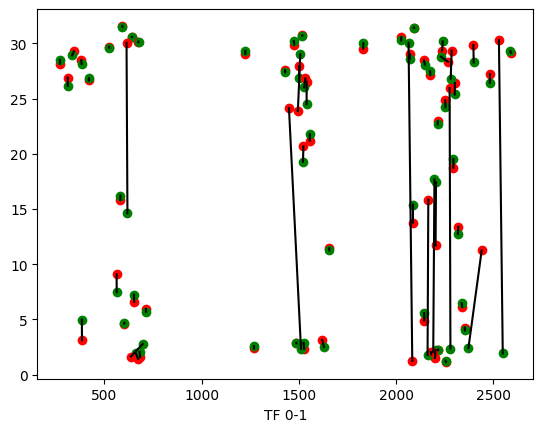

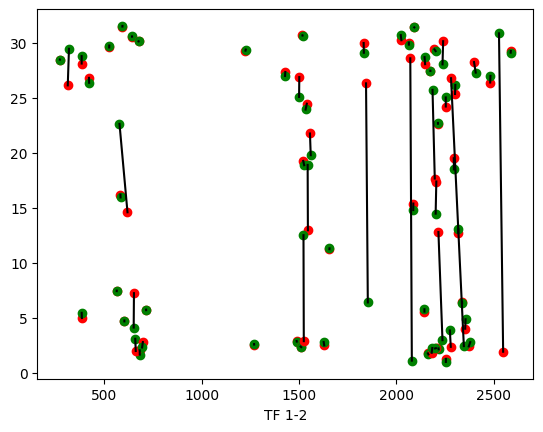

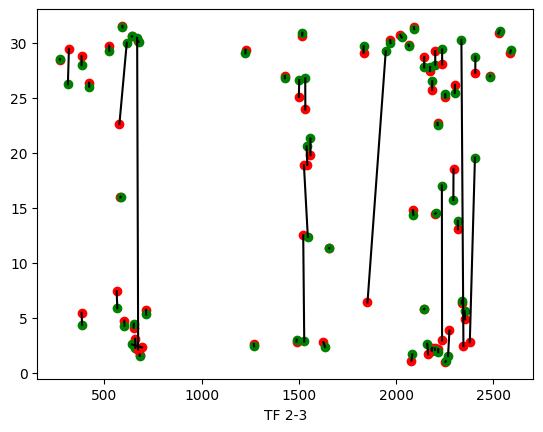

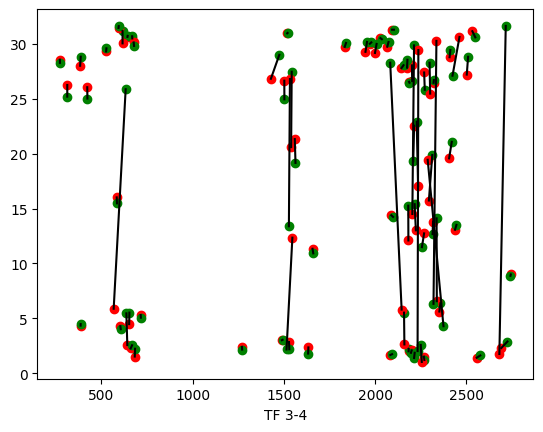

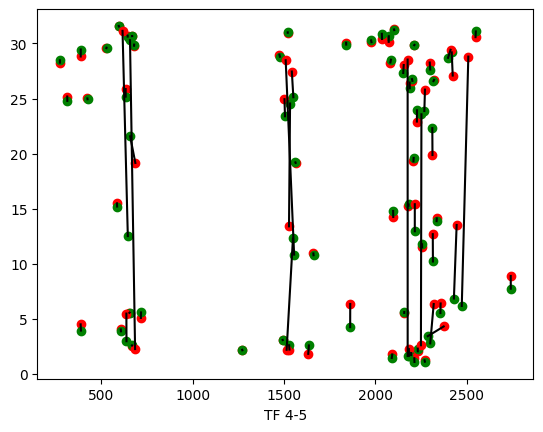

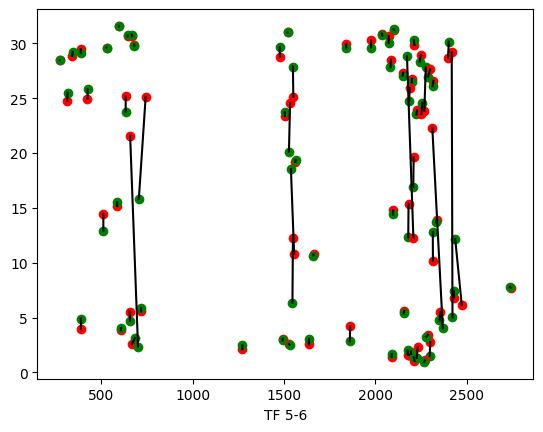

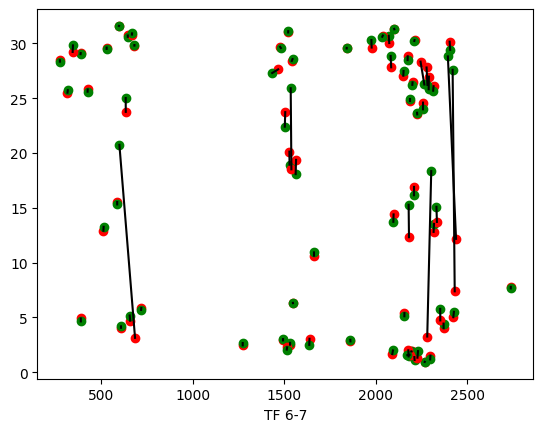

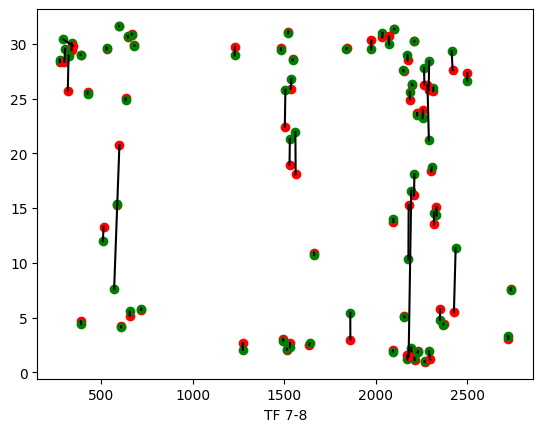

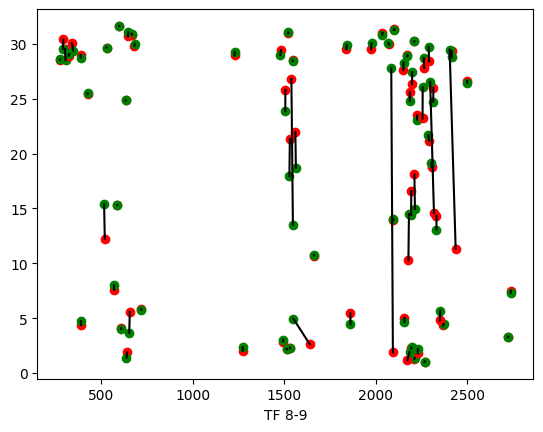

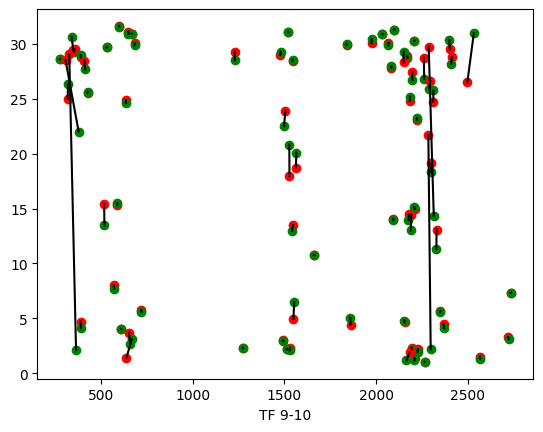

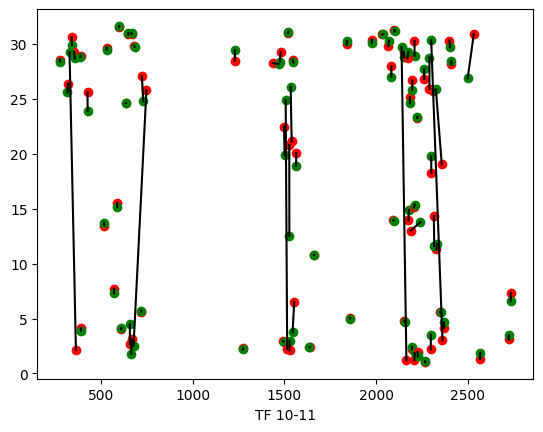

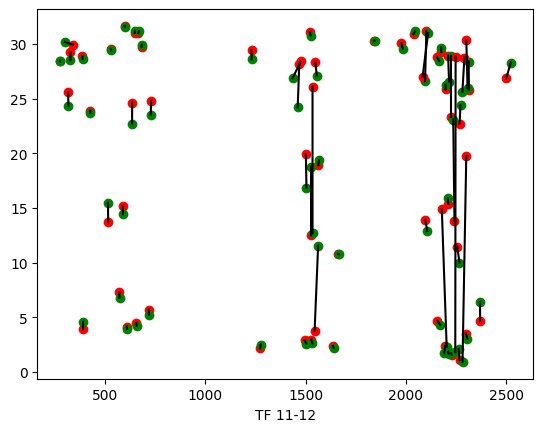

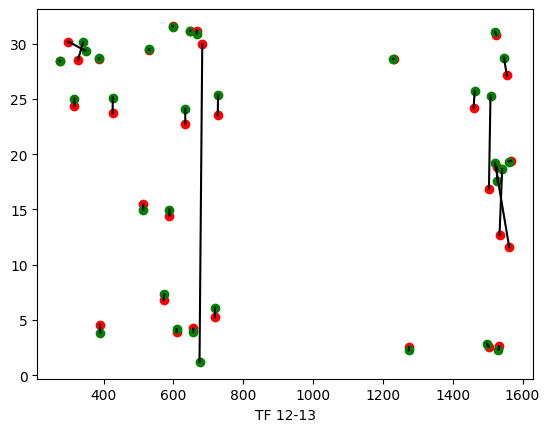

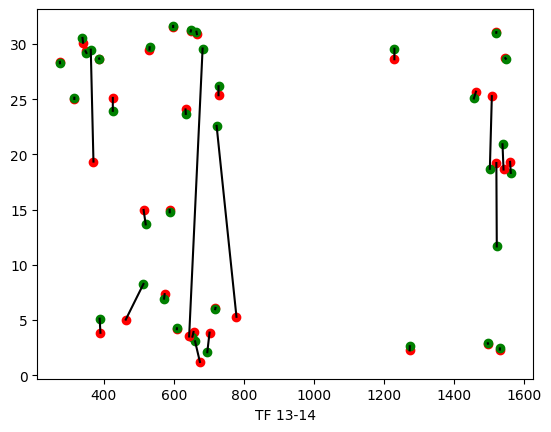

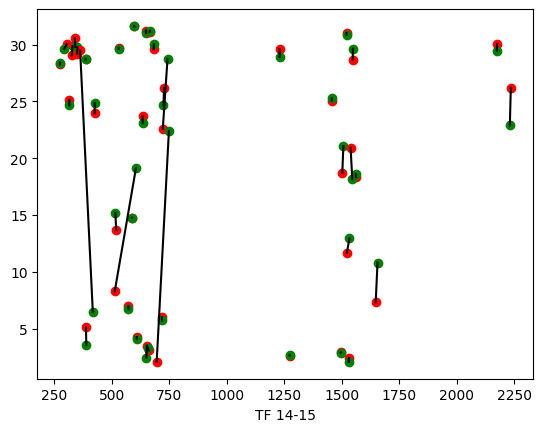

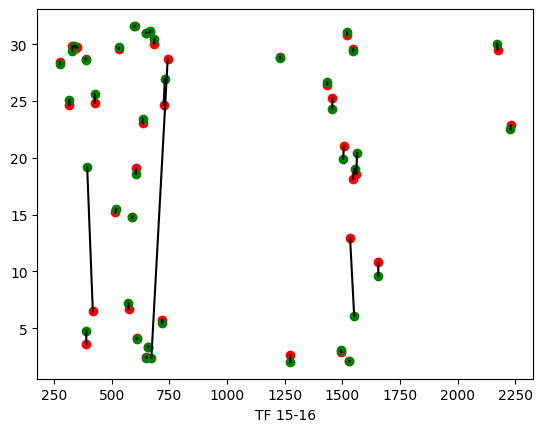

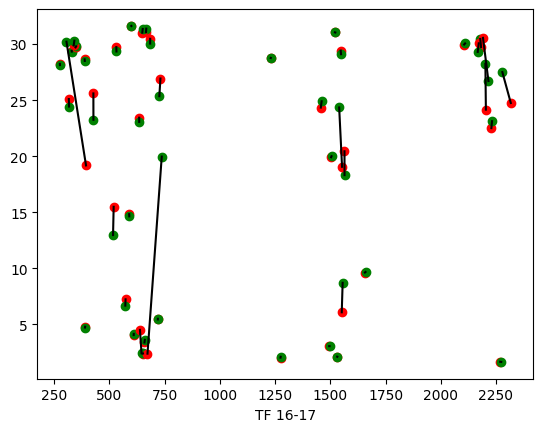

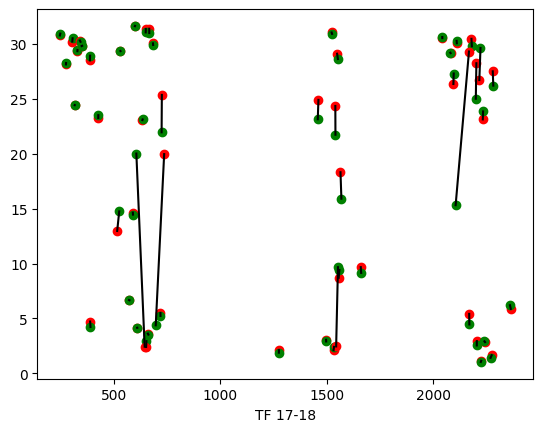

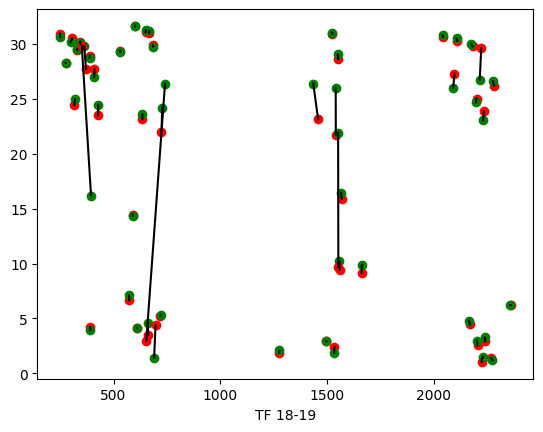

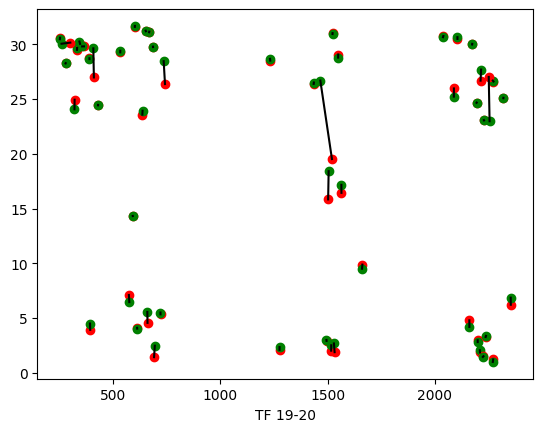

In [621]:
#color=iter(cm.rainbow(np.linspace(0,1,20)))
for t in range(0,20):
    for x,y in cluster_positions[t,t+1]:
        ax = plt.subplot(1,1,1)
        i = cluster_positions[(t,t+1)][x,y][0]
        j = cluster_positions[(t,t+1)][x,y][1]
        #c=next(color)
        ax.scatter(i[1],i[0], c = 'red')#, color=c)
        ax.scatter(j[1],j[0], c = 'green')#,color=c)
        plt.plot([i[1],j[1]],[i[0],j[0]],'k-')
    #plt.xlim((0,40))       
    #plt.ylim((1200,1800))
    plt.xlabel('TF {:d}-{:d}'.format(t,t+1))
    plt.show()

/disk/scratch/rarest/anaconda3/envs/spiketutorial/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


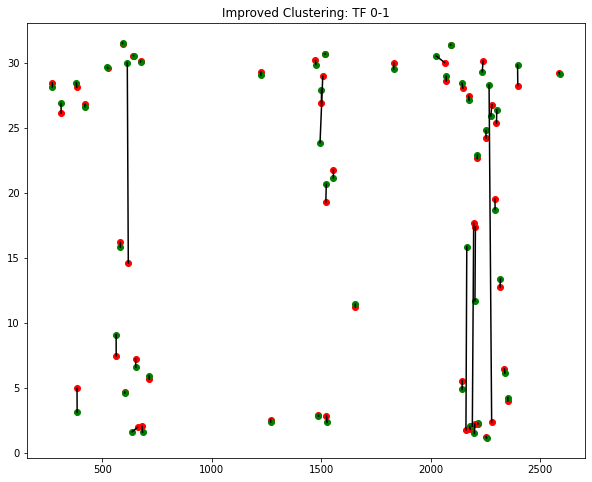

In [434]:
color=iter(cm.rainbow(np.linspace(0,1,20)))
plt.figure(figsize=(10,8))
for x,y in cluster_positions[0,1]:
    ax = plt.subplot(1,1,1)
    i = cluster_positions[(0,1)][x,y][0] #clsuter1 from pair
    j = cluster_positions[(0,1)][x,y][1] #cluster2 from pair
    #c=next(color)
    ax.scatter(i[1],i[0], c = 'red') #,color=c)
    ax.scatter(j[1],j[0], c = 'green')  #,color=c)
    plt.plot([i[1],j[1]],[i[0],j[0]],'k-')
#plt.xlim((0,40))       
#plt.ylim((1200,1800))
plt.title('Improved Clustering: TF {:d}-{:d}'.format(0,1))
plt.show()

/disk/scratch/rarest/anaconda3/envs/spiketutorial/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


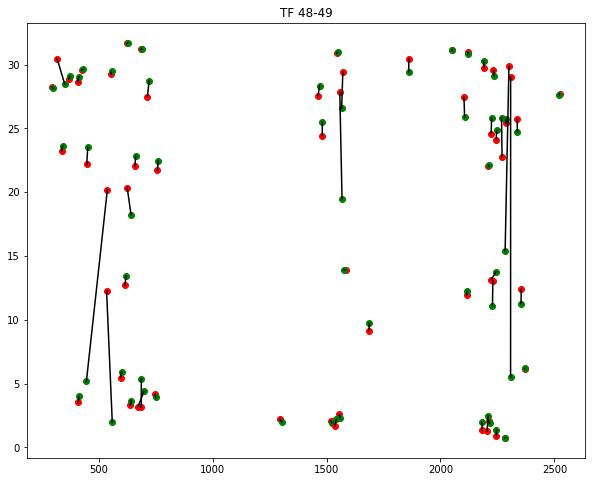

In [470]:
color=iter(cm.rainbow(np.linspace(0,1,20)))
plt.figure(figsize=(10,8))
for x,y in cluster_positions[48,49]:
    ax = plt.subplot(1,1,1)
    i = cluster_positions[(48,49)][x,y][0]
    j = cluster_positions[(48,49)][x,y][1]
    #c=next(color)
    ax.scatter(i[1],i[0], c = 'red') #,color=c)
    ax.scatter(j[1],j[0], c = 'green')  #,color=c)
    plt.plot([i[1],j[1]],[i[0],j[0]],'k-')
#plt.xlim((0,40))       
#plt.ylim((1200,1800))
plt.title('TF {:d}-{:d}'.format(48,49))
plt.show()

/disk/scratch/rarest/anaconda3/envs/spiketutorial/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


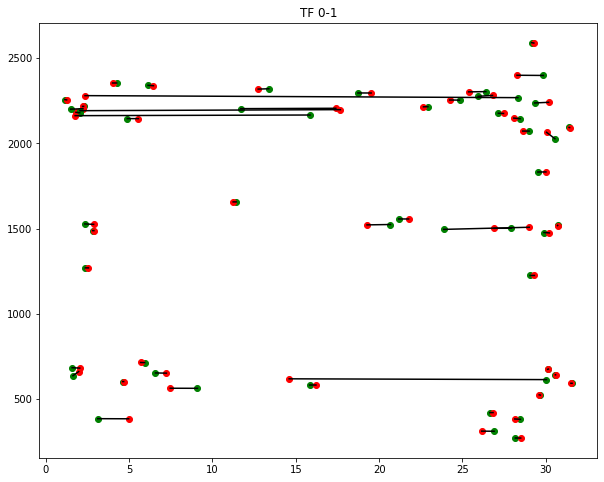

In [198]:
color=iter(cm.rainbow(np.linspace(0,1,20)))
plt.figure(figsize=(10,8))
for x,y in cluster_positions[0,1]:
    ax = plt.subplot(1,1,1)
    i = cluster_positions[(0,1)][x,y][0]
    j = cluster_positions[(0,1)][x,y][1]
    #c=next(color)
    ax.scatter(i[0],i[1], c = 'green') #,color=c)
    ax.scatter(j[0],j[1], c = 'red')  #,color=c)
    plt.plot([i[0],j[0]],[i[1],j[1]],'k-')
#plt.xlim((0,40))
plt.title('Baseline Clustering: TF {:d}-{:d}'.format(0,1))
#plt.ylim((1200,1800))
plt.show()

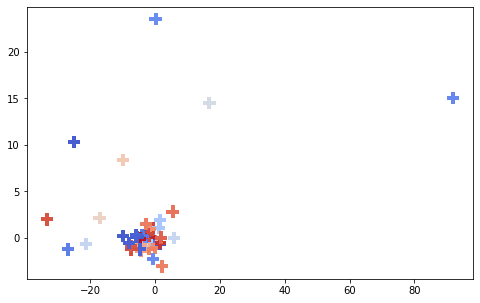

In [471]:
#shows whether all clusters move to the same direction
plt.figure(figsize=(8,5))
positions=[]
ax=[]
ay=[]
for x,y in tf_dict_dif[48,49]:
    ax.append(tf_dict_dif[48,49][x,y][1])
    ay.append(tf_dict_dif[48,49][x,y][0])
    positions.append(cluster_positions[48,49][x,y][1][0])
plt.scatter(ax,ay,s=150,marker='+',c=positions,linewidths=4, cmap=plt.cm.coolwarm)

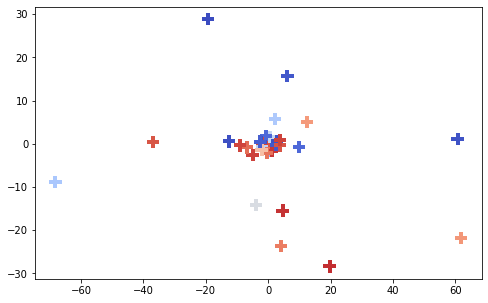

In [460]:
#shows whether all clusters move to the same direction
plt.figure(figsize=(8,5))
positions=[]
ax=[]
ay=[]
for x,y in tf_dict_dif[0,1]:
    ax.append(tf_dict_dif[0,1][x,y][1])
    ay.append(tf_dict_dif[0,1][x,y][0])
    positions.append(cluster_positions[0,1][x,y][1][0])
plt.scatter(ax,ay,s=150,marker='+',c=positions,linewidths=4, cmap=plt.cm.coolwarm)

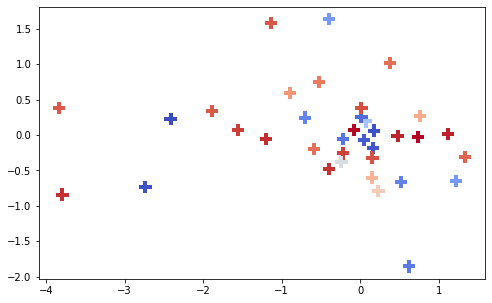

In [14]:
#shows whether all clusters move to the same direction
plt.figure(figsize=(8,5))
positions=[]
ax=[]
ay=[]
for x,y in cleaned_data[0,1]:
    ax.append(cleaned_data[0,1][x,y][1])
    ay.append(cleaned_data[0,1][x,y][0])
    positions.append(cluster_positions[0,1][x,y][1][0])
plt.scatter(ax,ay,s=150,marker='+',c=positions,linewidths=4, cmap=plt.cm.coolwarm)
#plt.scatter(ax,ay,s=150,marker='+',c='r',linewidths=4)

## Avg Disp - tf_dict

In [314]:
len(tf_dict_dif[23,24])

50

In [447]:
dict_avg_disp = {}
dict_std = {}
for t in range(len(time_frames)-1):
    distances = []
    for x,y in tf_dict_dif[t,t+1]:
        distances.append(tf_dict_dif[t,t+1][x,y])
    npdistances=np.array(distances)
    dict_avg_disp[t,t+1] = npdistances.mean(axis=0)
    dict_std[t,t+1] = np.std(npdistances,axis=0) 

In [106]:
dict_avg_disp[23,24]

array([-0.62043977, -3.13746931])

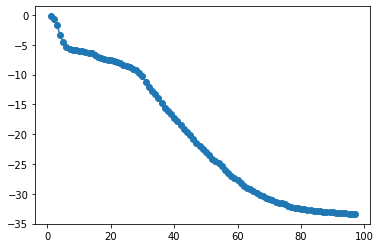

In [50]:
plt.plot(np.array(time_frames)[1:], np.cumsum([dict_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)]), 'o-')

Text(0, 0.5, 'Avg Displacement')

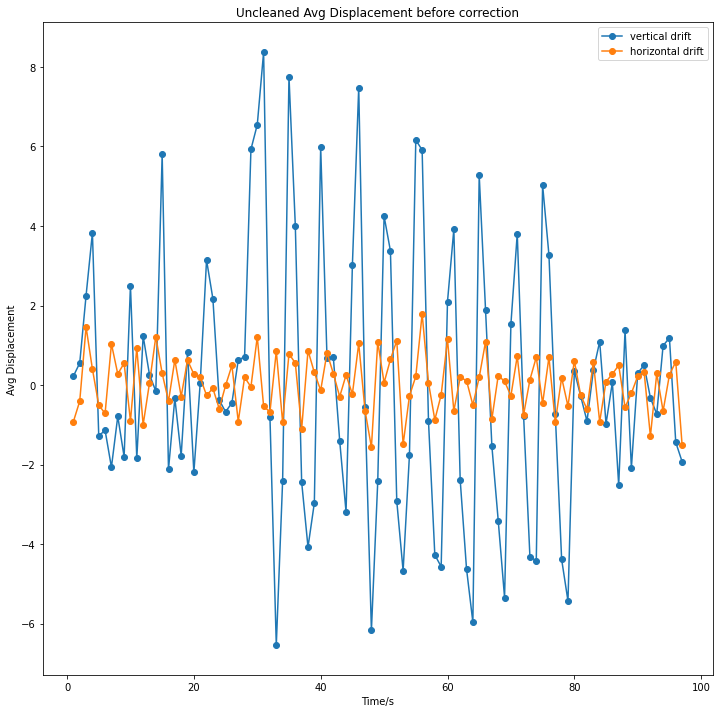

In [448]:
plt.figure(figsize=(12,12))
#for t in range(len(time_frames)-1):
    #ax = plt.subplot(1,1,1)
#    plt.scatter(time_frames[t], dict_avg_disp[t,t+1][0])
plt.plot(np.array(time_frames)[1:], [dict_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [dict_avg_disp[t,t+1][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift
plt.legend(['vertical drift', 'horizontal drift'], loc = "upper right")
plt.title('Uncleaned Avg Displacement before correction')
plt.xlabel('Time/s')
plt.ylabel('Avg Displacement')
#plt.ylim((-2.5, 2.0))

## Cleaned Data

In [449]:
cleaned_data = {}
ll_of_disp=[]
for t in range(len(time_frames)-1):
    cleaned_data_dict={}
    list_of_disp = []
    for x,y in tf_dict_dif[t,t+1]:
        y_threshold = (dict_avg_disp[t,t+1][0] - dict_std[t,t+1][0]/2, dict_avg_disp[t,t+1][0] + dict_std[t,t+1][0]/2)
        x_threshold = (dict_avg_disp[t,t+1][1] - dict_std[t,t+1][1]/2, dict_avg_disp[t,t+1][1] + dict_std[t,t+1][1]/2)
        if tf_dict_dif[t,t+1][x,y][0] > y_threshold[0] and tf_dict_dif[t,t+1][x,y][0] < y_threshold[1] and tf_dict_dif[t,t+1][x,y][1] > x_threshold[0] and tf_dict_dif[t,t+1][x,y][1] < x_threshold[1]:
            cleaned_data_dict[x,y] = tf_dict_dif[t,t+1][x,y]
            list_of_disp.append(tf_dict_dif[t,t+1][x,y])
    cleaned_data[(t,t+1)] = cleaned_data_dict
    ll_of_disp.append(list_of_disp)

In [278]:
print(len(cleaned_data))

97


## Histograms - cleaned data

In [464]:
#unclaned data
#tf01
distances = []
hist_distances_x = []
hist_distances_y = []
for x,y in cleaned_data[0,1]:
    distances.append(tf_dict_dif[0,1][x,y])
for i in range(len(distances)):
    hist_distances_x.append(distances[i][1])
    hist_distances_y.append(distances[i][0])

Text(0.5, 1.0, 'TF 0-1')

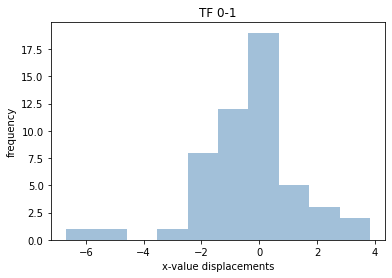

In [465]:
plt.hist(hist_distances_x, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');
plt.xlabel('x-value displacements')
plt.ylabel('frequency')
plt.title('TF 0-1')

In [468]:
#unclaned data
#tf4849
distances = []
hist_distances_x_mid = []
hist_distances_y_mid = []
for x,y in cleaned_data[48,49]:
    distances.append(tf_dict_dif[48,49][x,y])
for i in range(len(distances)):
    hist_distances_x_mid.append(distances[i][1])
    hist_distances_y_mid.append(distances[i][0])

Text(0.5, 1.0, 'TF 48-49')

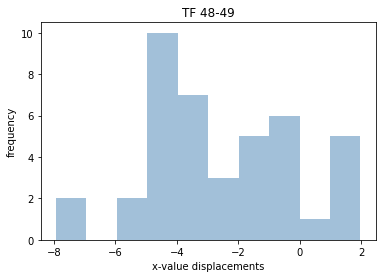

In [469]:
plt.hist(hist_distances_x_mid, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');
plt.xlabel('x-value displacements')
plt.ylabel('frequency')
plt.title('TF 48-49')

In [466]:
#tf01
distances = []
hist_distances_x = []
hist_distances_y = []
for x,y in cleaned_data[0,1]:
    distances.append(cleaned_data[0,1][x,y])
for i in range(len(distances)):
    hist_distances_x.append(distances[i][1])
    hist_distances_y.append(distances[i][0])

Text(0.5, 1.0, 'TF 0-1')

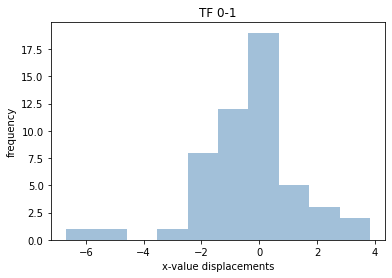

In [467]:
plt.hist(hist_distances_x, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');
plt.xlabel('x-value displacements')
plt.ylabel('frequency')
plt.title('TF 0-1')

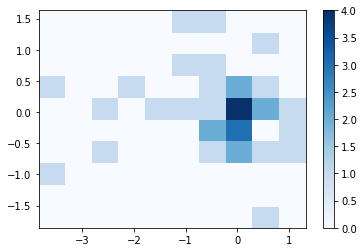

In [17]:
#choose a time frame with imposed drift
plt.hist2d(hist_distances_x, hist_distances_y, cmap='Blues')
plt.colorbar()

## Box Plot

In [504]:
print(time_frames)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]


In [77]:
data = []
for t in range(5):
    x_values = []
    for x,y in cleaned_data[t,t+1]:
        x_values.append(cleaned_data[t,t+1][x,y][1])
    data.append(x_values)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc990729e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc99073a4a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc99077c400>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc99073aa58>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc99073ad30>,
 'means': []}

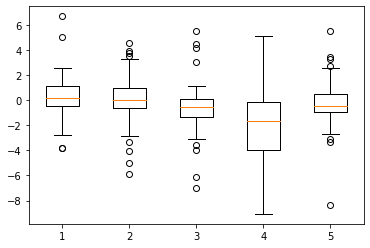

In [78]:
fig, ax = plt.subplots()
ax.boxplot(data)

 ## Avg Disp - Cleaned Data

In [80]:
cleaned_data[23,24]

{(22, 42): array([-0.03230746,  0.03053275]),
 (34, 23): array([0.29513804, 0.16411787]),
 (24, 22): array([-0.15506327,  0.34726734]),
 (0, 0): array([-0.24188418,  0.3743941 ]),
 (8, 6): array([-0.09233164,  0.45402763]),
 (31, 32): array([-0.369626  , -0.40152287]),
 (18, 17): array([ 0.2311559 , -0.53436465]),
 (40, 33): array([-0.44323057,  0.44483335]),
 (15, 13): array([-0.48272621, -0.42822766]),
 (25, 25): array([-0.23124384,  0.63069882]),
 (46, 49): array([ 0.19377485, -0.67675034]),
 (19, 16): array([-0.01606404,  0.81417548]),
 (7, 5): array([-0.73965391,  0.35952834]),
 (3, 2): array([-0.00218074,  0.82955985]),
 (30, 31): array([-0.61700758,  0.58888649]),
 (21, 20): array([-0.80044306,  0.41732955]),
 (11, 18): array([-0.14569903, -0.89333927]),
 (6, 4): array([-0.15686518,  0.93494015]),
 (4, 12): array([-0.2804791 ,  0.93651852]),
 (17, 30): array([-0.09317516,  0.98750914]),
 (47, 43): array([-0.11103801,  1.06080329]),
 (20, 15): array([-0.28482948,  1.03311163]),
 

In [450]:
cleaned_avg_disp = {}
cleaned_std = {}
for t in range(len(time_frames)-1):
    dist = []
    for x,y in cleaned_data[t,t+1]:
        dist.append(cleaned_data[t,t+1][x,y])
    npdist=np.array(dist)
    cleaned_avg_disp[t,t+1] = npdist.mean(axis=0)
    cleaned_std[t,t+1] = np.std(npdist,axis=0) 

In [97]:
print(cleaned_avg_disp[23,24])

[-0.1382278  -0.27397619]


In [340]:
l = list(iter(cleaned_avg_disp.values()))

In [341]:
s_list_r=[]
disp_dict={}
p_of_r = int(len(time_frames)/2)
for t in reversed(range(int(len(time_frames)/2))):
    s_list_r.append(l[t])
    disp_dict[t,p_of_r] = -sum(s_list_r)
#print(disp_dict)
disp_dict_2={}
s_list=[]
for t in range(int(len(time_frames)/2),int(len(time_frames)-1)):
    s_list.append(l[t])
    disp_dict_2[t+1,p_of_r] = -sum(s_list)
final_dict = dict(disp_dict)
final_dict.update(disp_dict_2)
#final_dict[p_of_r,p_of_r]=0

Text(0.5, 0, 'Time/s')

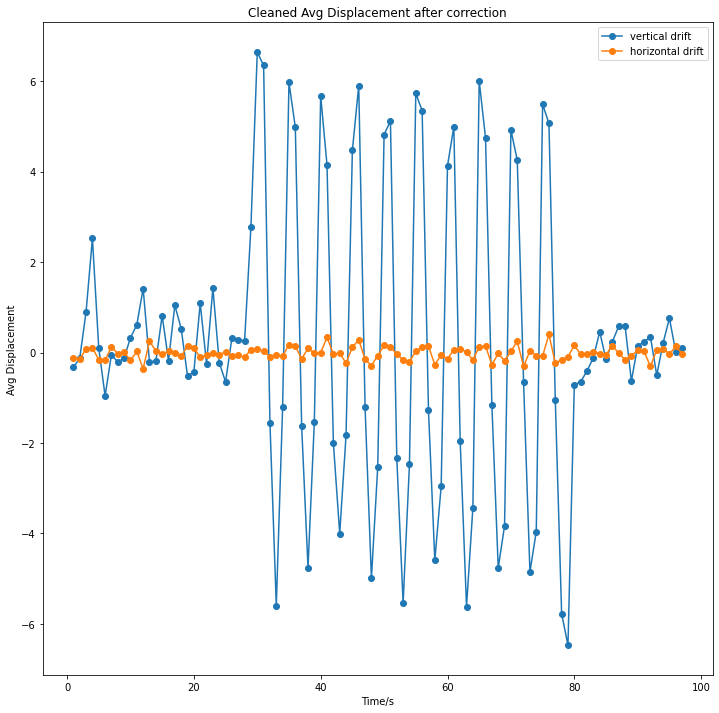

In [451]:
plt.figure(figsize=(12,12))
plt.plot(np.array(time_frames)[1:], [cleaned_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [cleaned_avg_disp[t,t+1][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift
plt.legend(['vertical drift', 'horizontal drift'], loc = "upper right")
plt.title('Cleaned Avg Displacement after correction')
plt.ylabel('Avg Displacement')
plt.xlabel('Time/s')
#plt.ylim((-8, 6))  #scaled
#plt.ylim((-2, 2))  #unscaled

Text(0.5, 0, 'Time/s')

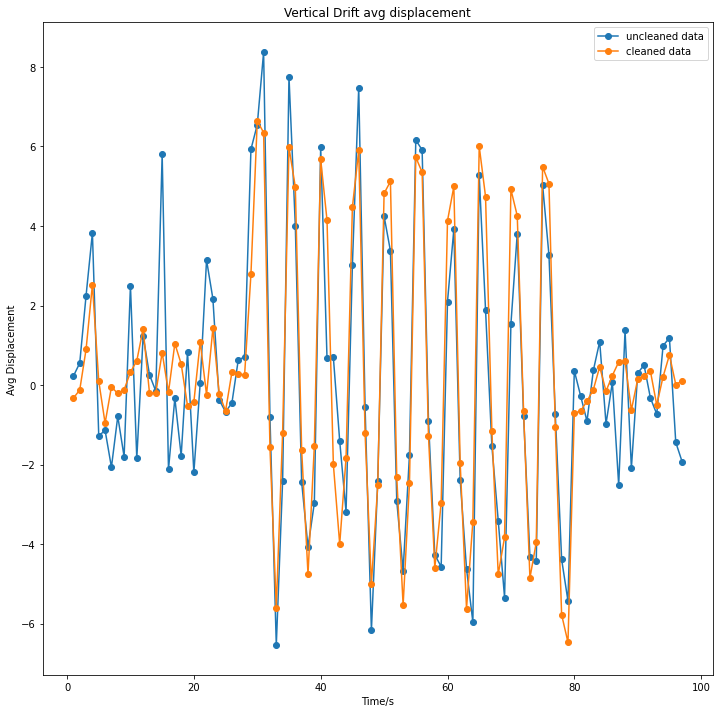

In [452]:
plt.figure(figsize=(12,12))
plt.plot(np.array(time_frames)[1:], [dict_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)],'o-')  
plt.plot(np.array(time_frames)[1:], [cleaned_avg_disp[t,t+1][1] for t in range(len(time_frames)-1)],'o-') 
plt.legend(['uncleaned data', 'cleaned data'], loc = "upper right")
plt.title('Vertical Drift avg displacement')
plt.ylabel('Avg Displacement')
plt.xlabel('Time/s')

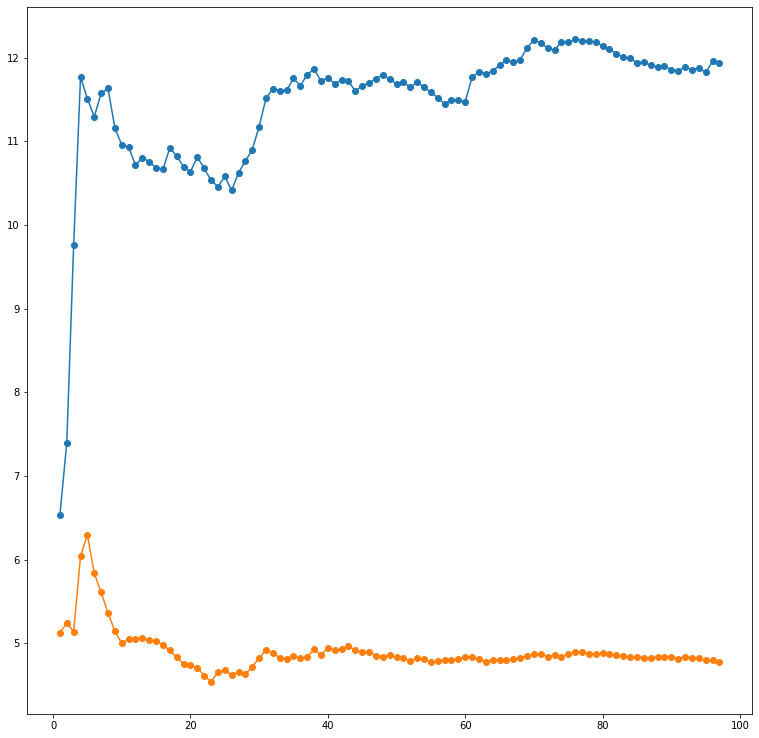

In [24]:
plt.figure(figsize=(13,13))
plt.plot(np.array(time_frames)[1:], [dict_std[t,t+1][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [dict_std[t,t+1][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift

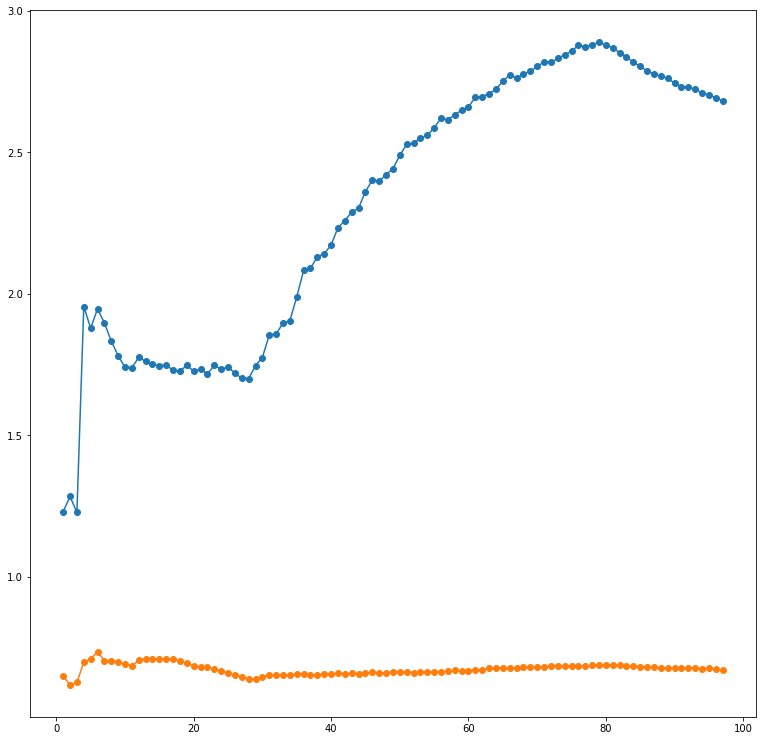

In [25]:
plt.figure(figsize=(13,13))
plt.plot(np.array(time_frames)[1:], [cleaned_std[t,t+1][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [cleaned_std[t,t+1][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift

In [332]:
print(final_dict)

{(48, 49): array([0.01661332, 0.09872026]), (47, 49): array([0.03612124, 0.24031711]), (46, 49): array([0.05844437, 0.42094157]), (45, 49): array([0.08009222, 0.63776537]), (44, 49): array([0.0998333 , 0.76061074]), (43, 49): array([0.11813817, 0.80522477]), (42, 49): array([0.14367684, 0.89185249]), (41, 49): array([0.16910883, 1.02909448]), (40, 49): array([0.19878275, 1.22564029]), (39, 49): array([0.22109673, 1.34622148]), (38, 49): array([0.24453734, 1.42386431]), (37, 49): array([0.26807   , 1.53388737]), (36, 49): array([0.29386708, 1.68412185]), (35, 49): array([0.32076649, 1.88969785]), (34, 49): array([0.34486699, 2.00436668]), (33, 49): array([0.36821961, 2.0170243 ]), (32, 49): array([0.39145716, 2.05980336]), (31, 49): array([0.41347455, 2.16149584]), (30, 49): array([0.43530335, 2.31432116]), (29, 49): array([0.45773999, 2.40732351]), (28, 49): array([0.4824178 , 2.46358587]), (27, 49): array([0.5071146 , 2.46018211]), (26, 49): array([0.53338977, 2.4595758 ]), (25, 49): 

## Drift correction

In [454]:
#uncleaned data
dt=20
sf = 30000
maxt = np.max(spike_time)/sf
steps = np.arange(0,maxt*sf,dt*sf)
cumulative_displacements_uncleaned = np.cumsum([np.mean(np.array(d), axis=0) for d in ll_drifts], axis=0)
x = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements_uncleaned)[:,0])
y = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements_uncleaned)[:,1])

In [455]:
#cleaned data
dt=20
sf = 30000
maxt = np.max(spike_time)/sf
steps = np.arange(0,maxt*sf,dt*sf)
cumulative_displacements = np.cumsum([np.mean(np.array(d), axis=0) for d in ll_of_disp], axis=0)
x = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements)[:,0])
y = np.interp(np.arange(0,maxt*sf+1), steps[1:], np.array(cumulative_displacements)[:,1])

Text(0, 0.5, 'Cumulative displacement')

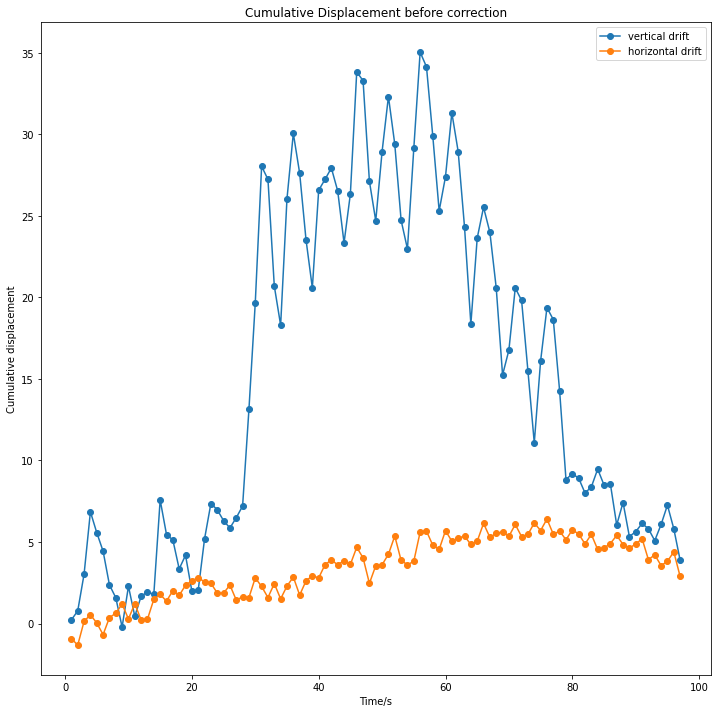

In [459]:
#uncleaned data
plt.figure(figsize=(12,12))
plt.plot(np.array(time_frames)[1:], [cumulative_displacements_uncleaned[t][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [cumulative_displacements_uncleaned[t][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift
plt.legend(['vertical drift', 'horizontal drift'], loc = "upper right")
plt.title('Cumulative Displacement before correction')
#plt.ylim((-8, 20))  #scaled
plt.xlabel('Time/s')
plt.ylabel('Cumulative displacement')

Text(0, 0.5, 'Cumulative displacement')

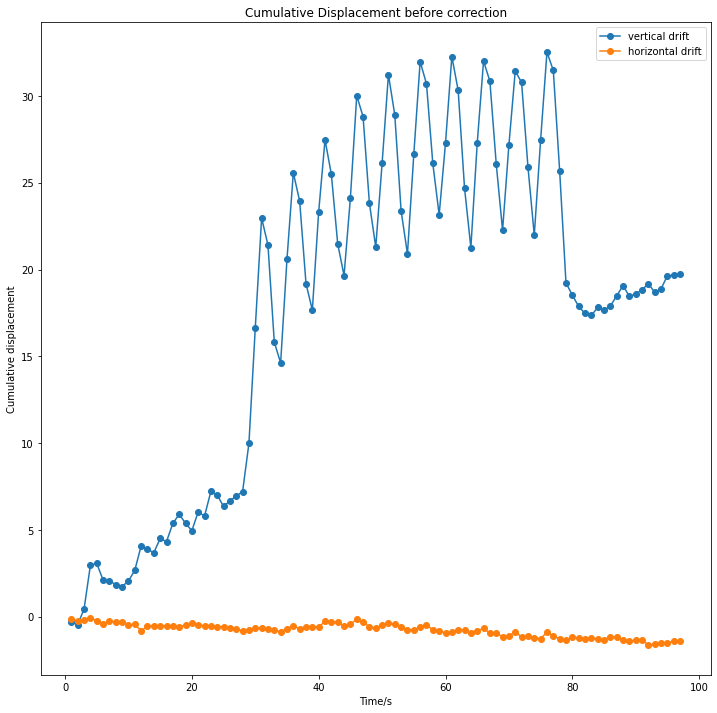

In [456]:
plt.figure(figsize=(12,12))
plt.plot(np.array(time_frames)[1:], [cumulative_displacements[t][1] for t in range(len(time_frames)-1)],'o-')   #horizontal drift
plt.plot(np.array(time_frames)[1:], [cumulative_displacements[t][0] for t in range(len(time_frames)-1)],'o-')   #vertical drift
plt.legend(['vertical drift', 'horizontal drift'], loc = "upper right")
plt.title('Cumulative Displacement before correction')
#plt.ylim((-8, 20))  #scaled
plt.xlabel('Time/s')
plt.ylabel('Cumulative displacement')

Text(0, 0.5, 'Cumulative displacement')

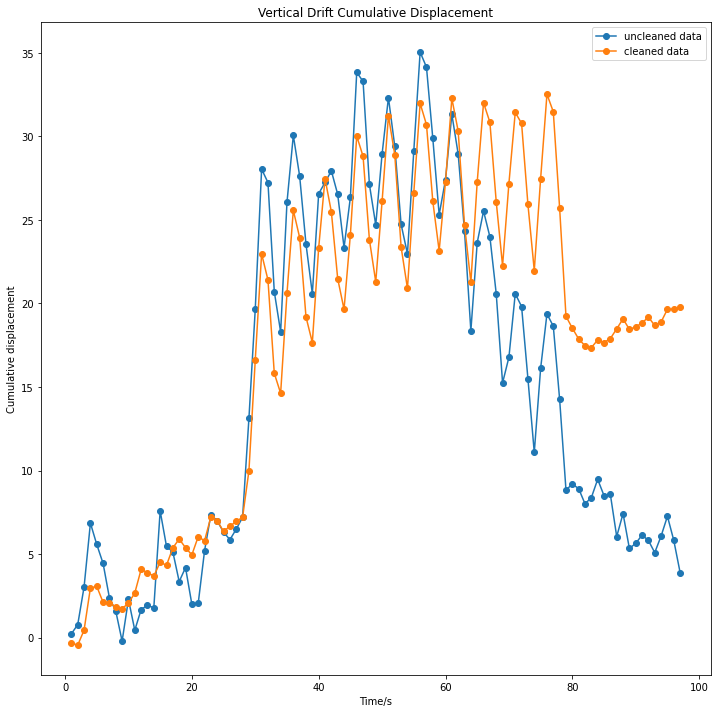

In [457]:
plt.figure(figsize=(12,12))
plt.plot(np.array(time_frames)[1:], [cumulative_displacements_uncleaned[t][1] for t in range(len(time_frames)-1)],'o-') 
plt.plot(np.array(time_frames)[1:], [cumulative_displacements[t][1] for t in range(len(time_frames)-1)],'o-')
plt.legend(['uncleaned data', 'cleaned data'], loc = "upper right")
plt.title('Vertical Drift Cumulative Displacement')
#plt.ylim((-8, 20))  #scaled
plt.xlabel('Time/s')
plt.ylabel('Cumulative displacement')

In [1401]:
inds = np.where ((spike_time>=0) & (spike_time<maxt*sf+1))[0]
print(len(inds))

973012


In [1435]:
x.shape, spike_loc.shape, spike_time.shape, maxt*sf, np.max(spike_time)

((2939999,), (2, 973012), (973012,), 58708450.0, 58708450)

In [400]:
interpolated_drift = np.vstack((x,y))
l_corrected = np.copy(spike_loc)
l_corrected[0] = l_corrected[0] - interpolated_drift[0][spike_time]
l_corrected[1] = l_corrected[1] - interpolated_drift[1][spike_time]

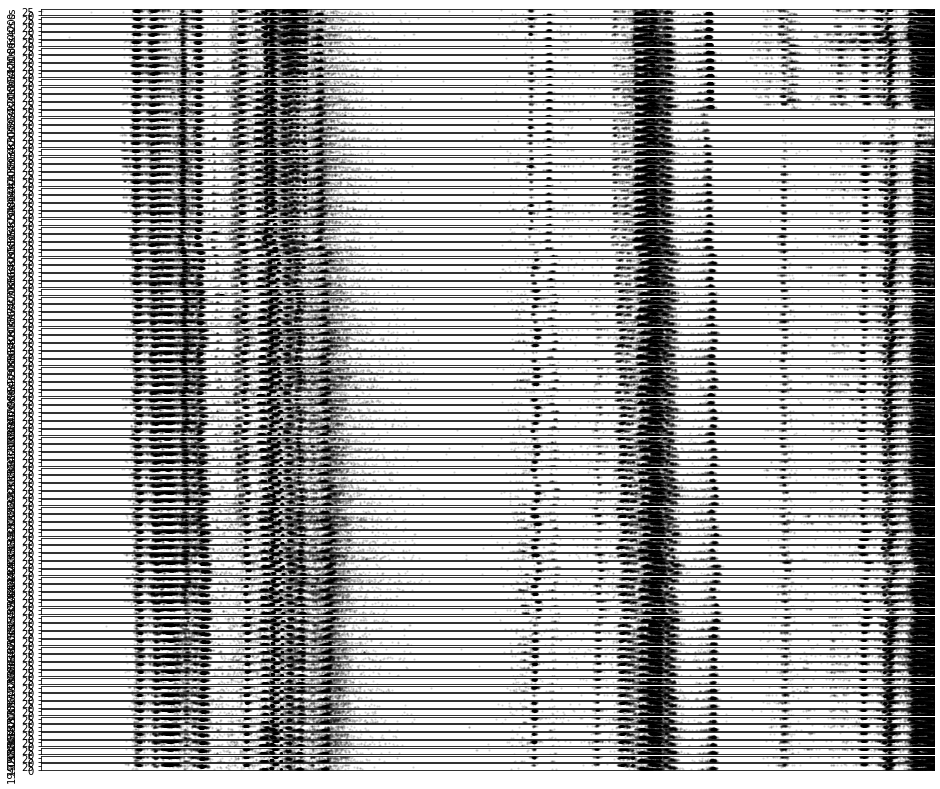

In [398]:
plt.figure(figsize=(16,14))
dt = 20
steps = np.arange(0,int(maxt),dt)
for j,i in enumerate(steps):         
    t0=i*sf        
    t1= (i+dt)*sf  
    
    inds = np.where ((spike_time>=t0) & (spike_time<t1))[0]# & (spike_loc[1]<1800) & (spike_loc[1]>1200)
    if i%10==0:
        ax = plt.subplot(len(steps),1,j+1)     
        y = l_corrected[0][inds]
        x = l_corrected[1][inds]
        ax.scatter(x,y, s=2, alpha=0.1, c='k')
        
        plt.ylabel('{:d}s'.format(int(t0/sf)))
        plt.xlim((40,2200))       
        plt.ylim((0,40))
        plt.xticks(())
#plt.xticks((1200,1400,1600,1800))

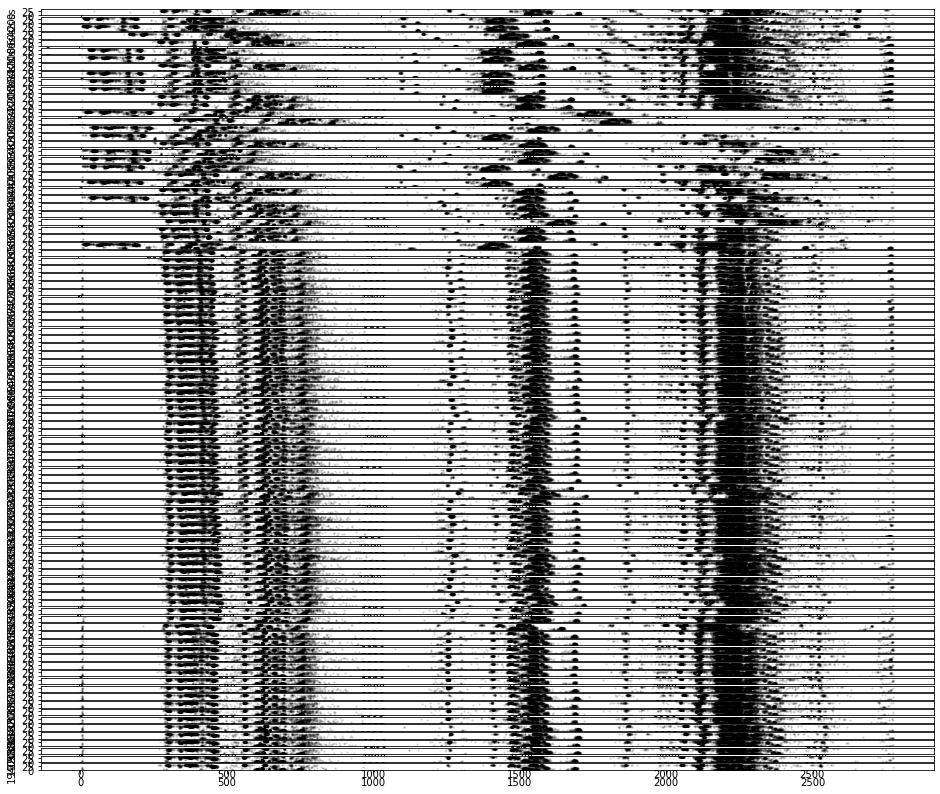

In [102]:
plt.figure(figsize=(16,14))         
l_corrected = np.copy(spike_loc)
dt = 20
steps = np.arange(0,int(maxt),dt)
for j,i in enumerate(steps):        
    t0=i*sf         
    t1= (i+dt)*sf  
    inds = np.where ((spike_time>=t0) & (spike_time<t1))[0]
    if j<len(time_frames)-1:
        l_corrected[0][inds] = l_corrected[0][inds] - cleaned_avg_disp[j, j+1][0]
        l_corrected[1][inds] = l_corrected[1][inds] - cleaned_avg_disp[j, j+1][1]
    if i%10==0:
        ax = plt.subplot(len(steps),1,j+1)
        y = l_corrected[0][inds]
        x = l_corrected[1][inds]
        ax.scatter(x,y, s=2, alpha=0.1, c='k')
        
        plt.ylabel('{:d}s'.format(int(t0/sf)))
        #plt.xlim((40,2200))       
        plt.ylim((0,40))
        #plt.xticks(())       

Number of clusters for time interval 0: 71
Number of clusters for time interval 1: 71
Number of clusters for time interval 2: 64
Number of clusters for time interval 3: 78
Number of clusters for time interval 4: 81
Number of clusters for time interval 5: 82
Number of clusters for time interval 6: 78
Number of clusters for time interval 7: 80
Number of clusters for time interval 8: 80
Number of clusters for time interval 9: 77
Number of clusters for time interval 10: 87
Number of clusters for time interval 11: 81
Number of clusters for time interval 12: 65
Number of clusters for time interval 13: 38
Number of clusters for time interval 14: 40
Number of clusters for time interval 15: 41
Number of clusters for time interval 16: 47
Number of clusters for time interval 17: 55
Number of clusters for time interval 18: 55
Number of clusters for time interval 19: 61
Number of clusters for time interval 20: 59
Number of clusters for time interval 21: 57
Number of clusters for time interval 22: 6

([<matplotlib.axis.XTick at 0x7f425e99f470>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

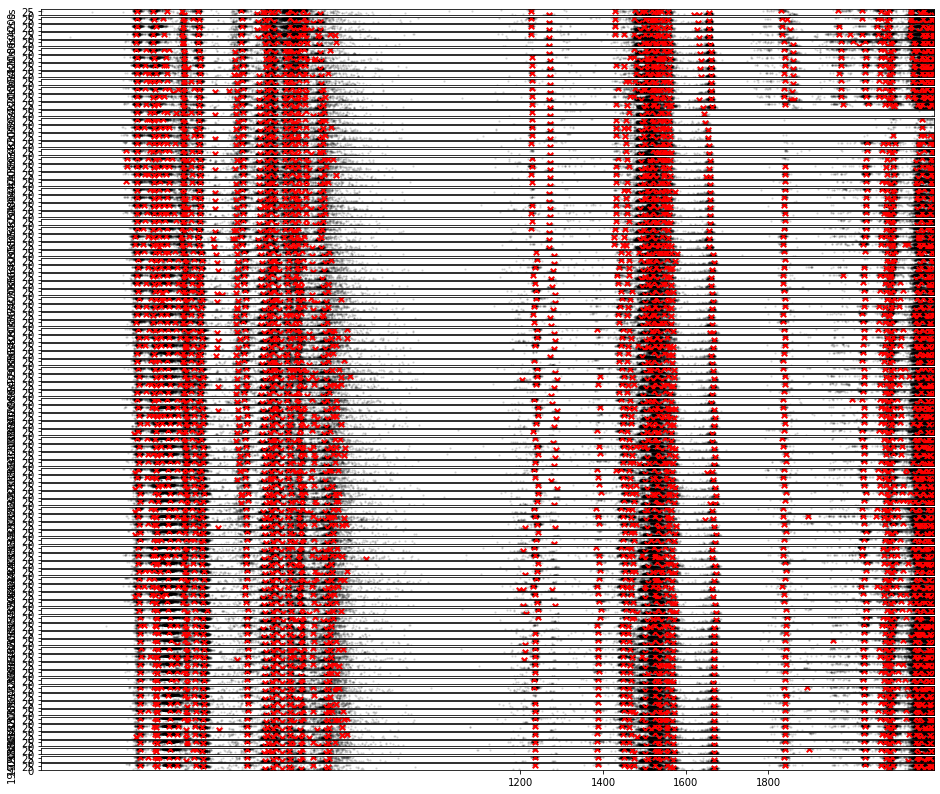

In [363]:
plt.figure(figsize=(16,14))
ms = MeanShift(bandwidth=6.5, bin_seeding=True, min_bin_freq=6)

cluster_centers_tf= []
time_frames = []
dt = 20
steps = np.arange(0,int(maxt),dt)
for j,i in enumerate(steps):
    t0=i*sf      #i*300k for every step
    t1=(i+dt)*sf  #take value of the next time step
    
    inds = np.where ((spike_time>=t0) & (spike_time<t1))[0]# & (spike_loc[1]<1800) & (spike_loc[1]>1200)
    X_clust = np.vstack((l_corrected[0,inds], l_corrected[1,inds]))
    #clustering
    ms.fit(X_clust.T)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters = len(np.unique(labels))
    print('Number of clusters for time interval %d: %d' %(j, n_clusters))
    cluster_centers_tf.append(cluster_centers)
    time_frames.append(j)
    if i%10==0:     #for each time stamp
        ax = plt.subplot(len(steps),1,j+1)     #nrows, nrcols, plot_no
        y = X_clust[0][:]
        x = X_clust[1][:]
        
        ax.scatter(x,y, s=2, alpha=0.1, c='k')
        ax.scatter(cluster_centers[:,1], cluster_centers[:,0], marker="x", color='r', s=30, linewidths=2)
        plt.ylabel('{:d}s'.format(int(t0/sf)))
    
        plt.xlim((40,2200))        #Get or set the x limits of the current axes
        plt.ylim((0,40))
        plt.xticks(())
plt.xticks((1200,1400,1600,1800))   
